In [1]:
#import packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
#from intake import open_catalog
import cartopy.io.shapereader as shpreader
#import mygrads as mg
import matplotlib as mpl
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature
from cartopy.feature import COASTLINE
import math
from sklearn.neighbors import NearestNeighbors

In [2]:
import dask.array as da

In [5]:
f='/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/MERRA2_400.inst1_2d_asm_Nx.20190223.SUB.nc'
DS_slp=xr.open_dataset(f)
DS_slp

<xarray.Dataset>
Dimensions:  (lat: 361, lon: 576, time: 24)
Coordinates:
  * time     (time) datetime64[ns] 2019-02-23 ... 2019-02-23T23:00:00
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
Data variables:
    SLP      (time, lat, lon) float32 ...
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    Conventions:                       CF-1
    History:                           Original file generated: Tue Mar  5 22...
    Comment:                           GMAO filename: d5124_m2_jan10.inst1_2d...
    Filename:                          MERRA2_400.inst1_2d_asm_Nx.20190223.nc4
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    RangeBeginningDate:                2019-02-23
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2019-02-23
    RangeEndingTime:                   23:00:00.000000
    history_L34RS:                     'Created by L34RS v1.4.2 @ NASA GES DI...
    CDO:                               Climate Data Operators version 1.9.8 (...

In [11]:
f='/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/MERRA2*.nc'
DS_slp=xr.open_mfdataset(f,combine='nested',concat_dim='time',chunks={'time':24,'lat':361, 'lon':576})
DS_slp

<xarray.Dataset>
Dimensions:  (lat: 361, lon: 576, time: 376944)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2021-09-30T23:00:00
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
Data variables:
    SLP      (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    Conventions:                       CF-1
    History:                           Original file generated: Sat May 31 18...
    Comment:                           GMAO filename: d5124_m2_jan79.inst1_2d...
    Filename:                          MERRA2_100.inst1_2d_asm_Nx.19800101.nc4
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    RangeBeginningDate:                1980-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   1980-01-01
    RangeEndingTime:                   23:00:00.000000
    history_L34RS:                     'Created by L34RS v1.4.2 @ NASA GES DI...
    CDO:                               Climate Data Operators version 1.9.8 (...

In [ ]:
print(DS_slp['time'].values)

In [12]:
winter_selected_slp=DS_slp.isel(time=DS_slp.time.dt.season.isin(['DJF']))
winter_selected_slp

<xarray.Dataset>
Dimensions:  (lat: 361, lon: 576, time: 93144)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-12-31T23:00:00
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
Data variables:
    SLP      (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    Conventions:                       CF-1
    History:                           Original file generated: Sat May 31 18...
    Comment:                           GMAO filename: d5124_m2_jan79.inst1_2d...
    Filename:                          MERRA2_100.inst1_2d_asm_Nx.19800101.nc4
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    RangeBeginningDate:                1980-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   1980-01-01
    RangeEndingTime:                   23:00:00.000000
    history_L34RS:                     'Created by L34RS v1.4.2 @ NASA GES DI...
    CDO:                               Climate Data Operators version 1.9.8 (...

In [13]:
all_slp_global_6hrly=winter_selected_slp['SLP'].resample(time='6H').mean(dim='time')
all_slp_global_6hrly

/homes/areed29/.conda/envs/clim680/lib/python3.6/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.DataArray 'SLP' (time: 62824, lat: 361, lon: 576)>
dask.array<where, shape=(62824, 361, 576), dtype=float32, chunksize=(1101, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-12-31T18:00:00
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0

In [14]:
all_slp_global_6hrly.to_netcdf('/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/6hrly_global_slp/6hrly_mslp_global.nc')

In [5]:
three_seasons=winter_selected_slp.sel(time=slice('1980-01-01','1983-02-28'))
three_seasons

<xarray.Dataset>
Dimensions:  (lat: 361, lon: 576, time: 7920)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 1983-02-28T23:00:00
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
Data variables:
    SLP      (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    Conventions:                       CF-1
    History:                           Original file generated: Sat May 31 18...
    Comment:                           GMAO filename: d5124_m2_jan79.inst1_2d...
    Filename:                          MERRA2_100.inst1_2d_asm_Nx.19800101.nc4
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    RangeBeginningDate:                1980-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   1980-01-01
    RangeEndingTime:                   23:00:00.000000
    history_L34RS:                     'Created by L34RS v1.4.2 @ NASA GES DI...
    CDO:                               Climate Data Operators version 1.9.8 (...

In [6]:
slp_resampled_3yr_global=three_seasons.resample(time='6H').mean(dim='time')
slp_resampled_3yr_global

/homes/areed29/.conda/envs/clim680/lib/python3.6/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.Dataset>
Dimensions:  (lat: 361, lon: 576, time: 4620)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 1983-02-28T18:00:00
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
Data variables:
    SLP      (time, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>

In [7]:
slp_resampled_3yr_global.to_netcdf('/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/6hrly_slp_global_test.nc')

### 6 HOURLY GLOBAL DATA FOR MSLP FOR 3 WINTERS (1980-1983)

In [2]:
f='/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/6hrly_slp_global_test.nc'
DS_slp_6hr=xr.open_dataset(f)
DS_slp_6hr

<xarray.Dataset>
Dimensions:  (lat: 361, lon: 576, time: 4620)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 1983-02-28T18:00:00
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
Data variables:
    SLP      (time, lat, lon) float32 ...

In [5]:
#slp_array=DS_slp_6hr.to_array()

In [3]:
slp_global_6hr=DS_slp_6hr['SLP']
slp_global_6hr

<xarray.DataArray 'SLP' (time: 4620, lat: 361, lon: 576)>
[960664320 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 1983-02-28T18:00:00
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0

In [7]:
import xesmf as xe

In [8]:
new_lat=np.arange(-90,90,0.5)
new_lon=np.arange(-180,180,0.5)

ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                    'lon': (['lon'], new_lon)
                    })

In [9]:
regridder=xe.Regridder(DS_slp_6hr,ds_out,'bilinear') 


Create weight file: bilinear_361x576_360x720.nc


In [10]:
dr_out=regridder(DS_slp_6hr['SLP']).to_dataset(name='SLP')
dr_out

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 4620)
Coordinates:
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * time     (time) datetime64[ns] 1980-01-01 ... 1983-02-28T18:00:00
Data variables:
    SLP      (time, lat, lon) float64 9.969e+04 9.969e+04 ... 9.838e+04 0.0

In [13]:
dr_out.to_netcdf('/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/slp_test_regrid.nc')

In [4]:
f='/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/slp_test_regrid.nc'
DS_slp_regrid=xr.open_dataset(f)
DS_slp_regrid

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 4620)
Coordinates:
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * time     (time) datetime64[ns] 1980-01-01 ... 1983-02-28T18:00:00
Data variables:
    SLP      (time, lat, lon) float64 ...

In [5]:
times=DS_slp_regrid['time']
times

<xarray.DataArray 'time' (time: 4620)>
array(['1980-01-01T00:00:00.000000000', '1980-01-01T06:00:00.000000000',
       '1980-01-01T12:00:00.000000000', ..., '1983-02-28T06:00:00.000000000',
       '1983-02-28T12:00:00.000000000', '1983-02-28T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 1983-02-28T18:00:00

In [6]:
slp_regrid_array=DS_slp_regrid['SLP']
slp_regrid_array

<xarray.DataArray 'SLP' (time: 4620, lat: 360, lon: 720)>
[1197504000 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * time     (time) datetime64[ns] 1980-01-01 ... 1983-02-28T18:00:00
Attributes:
    regrid_method:  bilinear

In [7]:
print(slp_regrid_array.values)

KeyboardInterrupt: 

In [8]:
lons=DS_slp_regrid['lon']
lats=DS_slp_regrid['lat']
#print(lats)

In [9]:
import pyshtools as pysh #ncar package to transform grid to spherical harmonics


In [42]:
'''
import numpy as np
import matplotlib.pyplot as plt
filedir = '/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/'
filename = filedir+'6hrly_slp_global_test.nc'
nlon = 576; nlat = 361; nvar = 1; ntimes = 4620
varall = np.fromfile(filename,dtype='float32')
print(varall)
#varall = np.reshape(varall,(ntall,nvar,nlev,nlat*nlon+2))[:,:,:,1:(1+nlat*nlon)]
# extract variables at right level and for only Nov. 15 - Mar. 30 (136 days)
#it = 14 + np.arange(ntimes)
#v300 = np.reshape(varall[it,1,5,:],(-1,nlat,nlon))
#flip latitudes
# flip latitudes
#ilat = np.flip(np.arange(nlat))
#t850 = t850[:,ilat,:]
'''

"\nimport numpy as np\nimport matplotlib.pyplot as plt\nfiledir = '/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/'\nfilename = filedir+'6hrly_slp_global_test.nc'\nnlon = 576; nlat = 361; nvar = 1; ntimes = 4620\nvarall = np.fromfile(filename,dtype='float32')\nprint(varall)\n#varall = np.reshape(varall,(ntall,nvar,nlev,nlat*nlon+2))[:,:,:,1:(1+nlat*nlon)]\n# extract variables at right level and for only Nov. 15 - Mar. 30 (136 days)\n#it = 14 + np.arange(ntimes)\n#v300 = np.reshape(varall[it,1,5,:],(-1,nlat,nlon))\n#flip latitudes\n# flip latitudes\n#ilat = np.flip(np.arange(nlat))\n#t850 = t850[:,ilat,:]\n"

In [10]:
#total field filtered SLP
new_grid=[]
for i in range(len(slp_regrid_array)):
    clm=pysh.SHGrid.from_xarray(slp_regrid_array[i,:,:],'DH')
    clm_new=clm.expand(normalization='4pi')
    grid=pysh.expand.MakeGridDH(clm_new.coeffs)
    coeffs=pysh.expand.SHExpandDH(grid)
    coeffs_filtered2 = coeffs.copy() #bandpass filters the data based on spherical harmonic coefficients
    lmin, lmax = 5,71
    coeffs_filtered2[:, :lmin, :] = 0.
    coeffs_filtered2[:, lmax:, :] = 0.
    grid_filtered2 = pysh.expand.MakeGridDH(coeffs_filtered2, sampling=2)
    #print(grid_filtered2)
    new_grid.append(grid_filtered2)

In [11]:
print(np.shape(new_grid))

(4620, 360, 720)


In [12]:
filtered_xarray=xr.DataArray(new_grid,coords={'lon':lons,'lat':lats,'time':times},dims=('time','lat','lon'))
filtered_xarray

<xarray.DataArray (time: 4620, lat: 360, lon: 720)>
array([[[ 1329.81594565,  1329.81594565,  1329.81594565, ...,
          1329.81594565,  1329.81594565,  1329.81594565],
        [ 1254.79087207,  1254.21198662,  1253.64301751, ...,
          1256.58667194,  1255.97825273,  1255.37963968],
        [ 1143.66188429,  1142.62758334,  1141.62842792, ...,
          1146.97532645,  1145.83580334,  1144.73130443],
        ...,
        [ 1026.07825759,  1026.36256614,  1026.70410217, ...,
          1025.56865227,  1025.68135221,  1025.85119562],
        [ 1042.60575594,  1042.80568117,  1043.02260743, ...,
          1042.10814083,  1042.25698353,  1042.42285378],
        [ 1033.0269508 ,  1033.11040512,  1033.19501212, ...,
          1032.78362093,  1032.86354874,  1032.94466172]],

       [[ 1356.60697615,  1356.60697615,  1356.60697615, ...,
          1356.60697615,  1356.60697615,  1356.60697615],
        [ 1287.11428186,  1286.70692311,  1286.30938198, ...,
          1288.39499405,  1287.95834701,  1287.5314326 ],
        [ 1172.50189851,  1171.73102286,  1170.99651021, ...,
          1175.03240483,  1174.15263434,  1173.30911478],
...
        [-1236.1301224 , -1239.71274204, -1243.24952999, ...,
         -1225.10886818, -1228.82798668, -1232.5018109 ],
        [-1258.41010705, -1260.95908314, -1263.49395949, ...,
         -1250.67986645, -1253.27035949, -1255.84715453],
        [-1279.18054104, -1280.54830472, -1281.9145358 , ...,
         -1275.06889764, -1276.44075177, -1277.81132838]],

       [[ 2767.71054351,  2767.71054351,  2767.71054351, ...,
          2767.71054351,  2767.71054351,  2767.71054351],
        [ 2536.22221108,  2535.34669507,  2534.49172463, ...,
          2538.97146462,  2538.03465583,  2537.11821746],
        [ 2259.90702519,  2258.22784823,  2256.60343827, ...,
          2265.27197769,  2263.42922322,  2261.64085875],
        ...,
        [-1694.14397024, -1698.604672  , -1703.00822621, ...,
         -1680.4220421 , -1685.05230722, -1689.62640626],
        [-1697.72252977, -1700.6765095 , -1703.61064078, ...,
         -1688.74370243, -1691.75589396, -1694.74891584],
        [-1713.67099193, -1715.13439801, -1716.59503208, ...,
         -1709.26528351, -1710.73631862, -1712.20492709]]])
Coordinates:
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * time     (time) datetime64[ns] 1980-01-01 ... 1983-02-28T18:00:00

In [13]:
filtered_xarray.to_netcdf('/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/slp6hr_spatialbandpass_3yrs_totalfield.nc')

In [14]:
#Anomalies 
slp_regrid_anoms=slp_regrid_array.groupby('time.hour')-slp_regrid_array.groupby('time.hour').mean(dim='time')
slp_regrid_anoms

<xarray.DataArray 'SLP' (time: 4620, lat: 360, lon: 720)>
array([[[  -13.1835464 ,   -13.1835464 ,   -13.1835464 , ...,
           -13.1835464 ,   -13.1835464 ,   -13.1835464 ],
        [   68.92843277,    69.14933885,    69.33225847, ...,
            68.39886803,    68.59990441,     0.        ],
        [  118.16889205,   118.62939583,   119.0841019 , ...,
           116.8068848 ,   117.26715117,     0.        ],
        ...,
        [ 1826.39048295,  1825.16746294,  1824.11967874, ...,
          1830.31569345,  1828.98921763,     0.        ],
        [ 1712.04621212,  1711.55288353,  1710.67814079, ...,
          1714.32965256,  1713.56223894,     0.        ],
        [ 1588.83259943,  1588.26629328,  1587.8949306 , ...,
          1589.37288762,  1589.19034096,     0.        ]],

       [[  -84.96441761,   -84.96441761,   -84.96441761, ...,
           -84.96441761,   -84.96441761,   -84.96441761],
        [  -25.45340909,   -25.34379158,   -25.24859671, ...,
           -25.7825341 ,   -25.66439243,     0.        ],
        [   14.10004735,    14.08827403,    14.01449441, ...,
            14.2857418 ,    14.2250549 ,     0.        ],
...
        [-2356.63390152, -2361.63828248, -2366.20769626, ...,
         -2341.94341551, -2346.82160455,     0.        ],
        [-2475.23231534, -2478.6082058 , -2481.96889249, ...,
         -2465.27032424, -2468.58217609,     0.        ],
        [-2576.07507102, -2577.77988053, -2579.46692502, ...,
         -2571.05267322, -2572.70860042,     0.        ]],

       [[  643.85002367,   643.85002367,   643.85002367, ...,
           643.85002367,   643.85002367,   643.85002367],
        [  586.59206913,   586.11694857,   585.65984509, ...,
           588.14306643,   587.64107027,     0.        ],
        [  488.67653883,   487.77751923,   486.89481181, ...,
           491.48120997,   490.53608445,     0.        ],
        ...,
        [-2889.7193892 , -2896.67933292, -2903.22802851, ...,
         -2869.10639515, -2875.92156721,     0.        ],
        [-3001.00641572, -3005.74682834, -3010.58279073, ...,
         -2986.71752653, -2991.4261869 ,     0.        ],
        [-3108.64150095, -3111.06994336, -3113.47572024, ...,
         -3101.49316431, -3103.85268263,     0.        ]]])
Coordinates:
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * time     (time) datetime64[ns] 1980-01-01 ... 1983-02-28T18:00:00
    hour     (time) int64 0 6 12 18 0 6 12 18 0 6 ... 12 18 0 6 12 18 0 6 12 18

In [15]:
#total field filtered SLP
new_grid_anoms=[]
for i in range(len(slp_regrid_anoms)):
    clm=pysh.SHGrid.from_xarray(slp_regrid_anoms[i,:,:],'DH')
    clm_new=clm.expand(normalization='4pi')
    grid=pysh.expand.MakeGridDH(clm_new.coeffs)
    coeffs=pysh.expand.SHExpandDH(grid)
    coeffs_filtered2 = coeffs.copy() #bandpass filters the data based on spherical harmonic coefficients
    lmin, lmax = 5,71
    coeffs_filtered2[:, :lmin, :] = 0.
    coeffs_filtered2[:, lmax:, :] = 0.
    grid_filtered2 = pysh.expand.MakeGridDH(coeffs_filtered2, sampling=2)
    #print(grid_filtered2)
    new_grid_anoms.append(grid_filtered2)

In [16]:
filtered_xarray_anoms=xr.DataArray(new_grid_anoms,coords={'lon':lons,'lat':lats,'time':times},dims=('time','lat','lon'))
filtered_xarray_anoms

<xarray.DataArray (time: 4620, lat: 360, lon: 720)>
array([[[    7.30420574,     7.30420574,     7.30420574, ...,
             7.30420574,     7.30420574,     7.30420574],
        [   84.45158817,    83.94479166,    83.43203844, ...,
            85.93584543,    85.44715386,    84.95238857],
        [  145.1611485 ,   144.17945303,   143.18704887, ...,
           148.04123355,   147.09211313,   146.13206008],
        ...,
        [  509.58252477,   508.86175429,   508.12443525, ...,
           511.64429177,   510.97392136,   510.28662266],
        [  416.3221354 ,   415.90397195,   415.47231276, ...,
           417.49510573,   417.11775688,   416.72674857],
        [  318.85138106,   318.66082692,   318.46301041, ...,
           319.37930374,   319.21063553,   319.03465604]],

       [[  -48.82540017,   -48.82540017,   -48.82540017, ...,
           -48.82540017,   -48.82540017,   -48.82540017],
        [   27.89717737,    27.61898684,    27.33520991, ...,
            28.69796416,    28.43669246,    28.16975476],
        [   83.24375533,    82.63470306,    82.01679335, ...,
            85.01712909,    84.43503242,    83.84388644],
...
        [-1752.64114419, -1757.31808565, -1762.02180786, ...,
         -1738.77392189, -1743.36877551, -1747.99127772],
        [-1882.51641156, -1885.74484577, -1888.98904996, ...,
         -1872.92777957, -1876.10767585, -1879.30395364],
        [-1988.94328796, -1990.61557223, -1992.29450583, ...,
         -1983.96748458, -1985.61912961, -1987.27776878]],

       [[ 1436.01846311,  1436.01846311,  1436.01846311, ...,
          1436.01846311,  1436.01846311,  1436.01846311],
        [ 1355.03037249,  1354.31435119,  1353.60313323, ...,
          1357.20671785,  1356.47660994,  1355.7511434 ],
        [ 1250.29745965,  1248.84288877,  1247.39737186, ...,
          1254.71401556,  1253.23317167,  1251.76093674],
        ...,
        [-2207.63062246, -2213.19422498, -2218.77380464, ...,
         -2191.04007994, -2196.55311238, -2202.08343863],
        [-2318.46628026, -2322.10633392, -2325.75661633, ...,
         -2307.61046184, -2311.21804833, -2314.83675291],
        [-2419.66325704, -2421.43568159, -2423.21355799, ...,
         -2414.38014755, -2416.13534507, -2417.89642983]]])
Coordinates:
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * time     (time) datetime64[ns] 1980-01-01 ... 1983-02-28T18:00:00

In [17]:
filtered_xarray_anoms.to_netcdf('/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/slp6hr_spatialbandpass_3yrs_anoms.nc')

In [8]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)


In [2]:
f='/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/slp6hr_spatialbandpass_3yrs_anoms.nc'
DS_filtered=xr.open_dataset(f)
DS_filtered

<xarray.Dataset>
Dimensions:                        (lat: 360, lon: 720, time: 4620)
Coordinates:
  * lon                            (lon) float64 -180.0 -179.5 ... 179.0 179.5
  * lat                            (lat) float64 -90.0 -89.5 -89.0 ... 89.0 89.5
  * time                           (time) datetime64[ns] 1980-01-01 ... 1983-...
Data variables:
    __xarray_dataarray_variable__  (time, lat, lon) float64 ...

In [10]:
#times=DS_filtered['time'].values
#times

In [17]:
values=DS_filtered['__xarray_dataarray_variable__']
values

<xarray.DataArray '__xarray_dataarray_variable__' (time: 4620, lat: 360, lon: 720)>
array([[[    7.304206,     7.304206, ...,     7.304206,     7.304206],
        [   84.451588,    83.944792, ...,    85.447154,    84.952389],
        ...,
        [  416.322135,   415.903972, ...,   417.117757,   416.726749],
        [  318.851381,   318.660827, ...,   319.210636,   319.034656]],

       [[  -48.8254  ,   -48.8254  , ...,   -48.8254  ,   -48.8254  ],
        [   27.897177,    27.618987, ...,    28.436692,    28.169755],
        ...,
        [  455.707543,   455.188946, ...,   456.705486,   456.213081],
        [  367.276328,   367.058618, ...,   367.690858,   367.487082]],

       ...,

       [[ 1513.927484,  1513.927484, ...,  1513.927484,  1513.927484],
        [ 1480.715998,  1480.413781, ...,  1481.321531,  1481.018587],
        ...,
        [-1882.516412, -1885.744846, ..., -1876.107676, -1879.303954],
        [-1988.943288, -1990.615572, ..., -1985.61913 , -1987.277769]],

       [[ 1436.018463,  1436.018463, ...,  1436.018463,  1436.018463],
        [ 1355.030372,  1354.314351, ...,  1356.47661 ,  1355.751143],
        ...,
        [-2318.46628 , -2322.106334, ..., -2311.218048, -2314.836753],
        [-2419.663257, -2421.435682, ..., -2416.135345, -2417.89643 ]]])
Coordinates:
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * time     (time) datetime64[ns] 1980-01-01 ... 1983-02-28T18:00:00

In [18]:
slp_dc=values.sel(lat=39,lon=-77,method='nearest')
slp_dc

<xarray.DataArray '__xarray_dataarray_variable__' (time: 4620)>
array([-113.454836, -125.210917, -221.574382, ...,  797.501098,  603.114645,
        454.416494])
Coordinates:
    lon      float64 -77.0
    lat      float64 39.0
  * time     (time) datetime64[ns] 1980-01-01 ... 1983-02-28T18:00:00

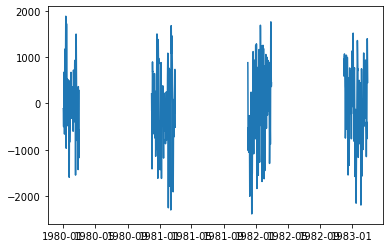

In [19]:
plt.plot(slp_dc['time'],slp_dc)

In [24]:
winter_only=DS_filtered.isel(time=DS_filtered.time.dt.season.isin(['DJF']))
winter_only

<xarray.Dataset>
Dimensions:                        (lat: 360, lon: 720, time: 1320)
Coordinates:
  * lon                            (lon) float64 -180.0 -179.5 ... 179.0 179.5
  * lat                            (lat) float64 -90.0 -89.5 -89.0 ... 89.0 89.5
  * time                           (time) datetime64[ns] 1980-01-01 ... 1983-...
Data variables:
    __xarray_dataarray_variable__  (time, lat, lon) float64 7.304 ... -2.418e+03

In [28]:
one_season=winter_only.sel(time=slice('1982-12-01','1983-02-28'))
one_season

<xarray.Dataset>
Dimensions:                        (lat: 360, lon: 720, time: 360)
Coordinates:
  * lon                            (lon) float64 -180.0 -179.5 ... 179.0 179.5
  * lat                            (lat) float64 -90.0 -89.5 -89.0 ... 89.0 89.5
  * time                           (time) datetime64[ns] 1982-12-01 ... 1983-...
Data variables:
    __xarray_dataarray_variable__  (time, lat, lon) float64 -552.9 ... -2.418...

In [26]:
one_season.to_netcdf('/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/slp6hr_spatialbandpass_winter19801981_anoms.nc')

In [22]:
winter=one_season.sel(lat=39,lon=-77,method='nearest')
winter

<xarray.DataArray '__xarray_dataarray_variable__' (time: 1320)>
array([-113.454836, -125.210917, -221.574382, ...,  797.501098,  603.114645,
        454.416494])
Coordinates:
    lon      float64 -77.0
    lat      float64 39.0
  * time     (time) datetime64[ns] 1980-01-01 ... 1983-02-28T18:00:00

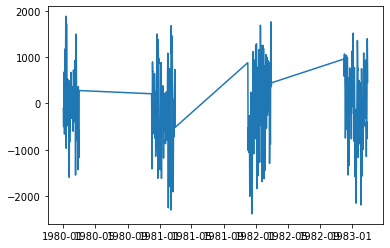

In [23]:
plt.plot(winter['time'],winter)

### One year isolated

In [8]:
clm = pysh.SHGrid.from_xarray(slp_regrid_array[0,:,:],'DH')
clm

kind = 'real'
grid = 'DH'
n = 360
sampling = 2
nlat = 360
nlon = 720
lmax = 179
extend = False

In [9]:
clm_new=clm.expand(normalization='4pi')
clm_new

kind = 'real'
normalization = '4pi'
csphase = 1
lmax = 179
header = None

In [10]:
grid=pysh.expand.MakeGridDH(clm_new.coeffs)
grid

array([[ 99554.06560173,  99554.06560173,  99554.06560173, ...,
         99554.06560173,  99554.06560173,  99554.06560173],
       [ 99272.65536212,  99273.29852955,  99274.17141862, ...,
         99272.11187554,  99272.06169537,  99272.24289922],
       [ 98843.9567039 ,  98845.9244455 ,  98849.01715279, ...,
         98844.85350594,  98843.42044469,  98843.12106715],
       ...,
       [102018.18542449, 102021.86057444, 102028.87807806, ...,
        102027.36050067, 102020.94284186, 102017.87831517],
       [102346.88167843, 102348.26135232, 102350.72668623, ...,
        102349.3013743 , 102347.40170414, 102346.59438461],
       [102631.79163191, 102631.87682486, 102632.15278867, ...,
        102632.68624425, 102632.19621627, 102631.89798193]])

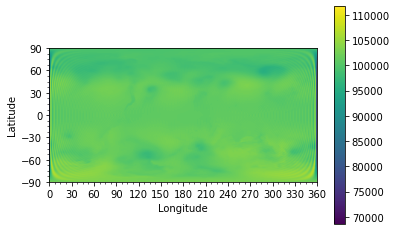

In [11]:
fig, ax = plt.subplots(1, 1)
image=ax.imshow(grid, extent=(0, 360, -90, 90))
ax.set(xlabel='Longitude', ylabel='Latitude', yticks=np.arange(-90, 120, 30), xticks=np.arange(0, 390, 30))
ax.minorticks_on()
plt.colorbar(image)

In [12]:
print(np.shape(grid))

(360, 360)


In [13]:
coeffs = pysh.expand.SHExpandDH(grid)
coeffs

array([[[ 1.00970015e+05,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-4.98723819e+02, -2.24834130e+02,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-2.09989225e+02, -2.65229083e+01, -2.94393467e+02, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 1.11109576e-02, -2.11297908e-01,  8.33907723e-02, ...,
         -1.81653092e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.14799201e-01,  6.91689203e-02, -2.60478581e-01, ...,
          3.41586957e-02, -1.34674439e+00,  0.00000000e+00],
        [-1.17587835e-04, -5.29729286e-02,  1.70352415e-01, ...,
         -1.32732362e+00, -1.68095325e-02, -6.33836563e-01]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -1.64482585e+01,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e

In [19]:
coeffs_filtered = coeffs.copy()
lmax = 5
coeffs_filtered[:, lmax:, :] = 0.

grid_filtered = pysh.expand.MakeGridDH(coeffs_filtered,sampling=2)
print(grid_filtered)

[[ 98213.86922248  98213.86922248  98213.86922248 ...  98213.86922248
   98213.86922248  98213.86922248]
 [ 98202.63440337  98202.65307767  98202.67267589 ...  98202.58393811
   98202.59983227  98202.61665445]
 [ 98192.09418751  98192.13172139  98192.17118998 ...  98191.99322265
   98192.02493545  98192.05859127]
 ...
 [101850.17672578 101849.83290859 101849.48659944 ... 101851.19296826
  101850.85678127 101850.51802524]
 [101837.95283612 101837.72308875 101837.49156732 ... 101838.63126126
  101838.40693956 101838.18079214]
 [101825.32486766 101825.20975035 101825.09369072 ... 101825.66447888
  101825.55224056 101825.43903395]]


In [25]:
coeffs_filtered2 = coeffs.copy() #bandpass filters the data based on spherical harmonic coefficients
lmin, lmax = 2,8
coeffs_filtered2[:, :lmin, :] = 0.
coeffs_filtered2[:, lmax:, :] = 0.
grid_filtered2 = pysh.expand.MakeGridDH(coeffs_filtered2, sampling=2)
print(grid_filtered2)

[[-892.01147743 -892.01147743 -892.01147743 ... -892.01147743
  -892.01147743 -892.01147743]
 [-916.77391691 -916.68066647 -916.58562077 ... -917.04283217
  -916.95500609 -916.86536558]
 [-942.25766558 -942.07656924 -941.89199765 ... -942.77998928
  -942.60938676 -942.43527517]
 ...
 [1275.31301474 1275.23433928 1275.14588656 ... 1275.49041065
  1275.44104678 1275.38191608]
 [1231.84664048 1231.78587023 1231.71820081 ... 1231.98755137
  1231.94748118 1231.9005109 ]
 [1185.63997404 1185.60543269 1185.56725646 ... 1185.7217734
  1185.6981457  1185.67087885]]


In [21]:
xr.DataArray(grid_filtered2)

<xarray.DataArray (dim_0: 360, dim_1: 720)>
array([[4714.07478773, 4714.07478773, 4714.07478773, ..., 4714.07478773,
        4714.07478773, 4714.07478773],
       [4448.11782656, 4446.06573107, 4444.04878808, ..., 4454.48377137,
        4452.32698141, 4450.20495341],
       [4054.17582188, 4050.50932048, 4046.96740675, ..., 4065.92166854,
        4061.88216426, 4057.96681758],
       ...,
       [3637.352718  , 3638.36056557, 3639.57127928, ..., 3635.54621417,
        3635.94572507, 3636.54780428],
       [3695.94117417, 3696.64989068, 3697.41887423, ..., 3694.17717456,
        3694.70480819, 3695.2928029 ],
       [3661.98519407, 3662.28103195, 3662.58095592, ..., 3661.12261216,
        3661.40594884, 3661.69348689]])
Dimensions without coordinates: dim_0, dim_1

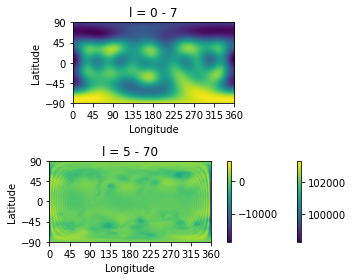

In [16]:
fig, (row1, row2) = plt.subplots(2, 1)
first=row1.imshow(grid_filtered, extent=(0, 360, -90, 90))
row1.set(xlabel='Longitude', ylabel='Latitude', title='l = 0 - 7', yticks=np.arange(-90,135,45), xticks=np.arange(0,405,45))
second=row2.imshow(grid_filtered2, extent=(0, 360, -90, 90))
row2.set(xlabel='Longitude', ylabel='Latitude', title='l = 5 - 70', yticks=np.arange(-90,135,45), xticks=np.arange(0,405,45))
fig.tight_layout()
fig.colorbar(first)
fig.colorbar(second)


In [46]:
xr_slp_filt=pysh.SHGrid.to_xarray(grid_filtered2)

AttributeError: 'numpy.ndarray' object has no attribute 'nlat'

In [31]:
p = pysh.legendre.PlON(lmax, )

SHToolsError: Improper bounds for input variable.